# Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Шаг 1. Откройте файл с данными и изучите общую информацию.

#### 1. Импортирем библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats as st
import math as mth

####  2.Считываем данные из csv-файлов в датафреймы и сохраняем в переменные

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep = '\t')

#### 3. Изучаем общую информацию о полученных датафреймах

In [3]:
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**на 1 шаге мы:**

1) импортировали библиотеки;

2) записали данные в датафрейм;

3) изучили общую информацию о полученном датафрейме.

## Шаг 2. Подготовьте данные.

#### 1. Замените названия столбцов на удобные для вас.

In [5]:
df.columns = ['event_name', 'user_id', 'timestamp', 'group']

####  2. Проверьте пропуски и типы данных.

In [6]:
#проверим на пропуски:
df.isna().sum()

event_name    0
user_id       0
timestamp     0
group         0
dtype: int64

In [7]:
#Проверим на явные дубликаты:
df.duplicated().sum()

413

In [8]:
#посчитаем долю
print(f"доля дубликатов {df.duplicated().sum()/df['user_id'].count():.1%}")

доля дубликатов 0.2%


In [9]:
#удалим явные дубликаты:
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
df.duplicated().sum()

0

#### 3. Добавьте столбец даты и времени, а также отдельный столбец дат

In [11]:
# Создадим поле `datetime` с датой и временем:
df['dt'] = pd.to_datetime(df['timestamp'], unit='s')

# Добавим поле с датой:
df['date'] = pd.to_datetime(df['dt'].dt.date)

#### 4. Проверим отсутствие пересечения пользователей в группах

In [12]:
#создадим списки уникальных пользователей в каждой группе
g246 = df.query('group == 246')['user_id'].unique()
g247 = df.query('group == 247')['user_id'].unique()
g248 = df.query('group == 248')['user_id'].unique()

In [13]:
#проверим пересечения в группах 246 и 247
intersection_1 = []
for i in g246:
  if i in g247:
    intersection_1.append(i)
print(len(intersection_1))

0


In [14]:
#проверим пересечения в группах 246 и 248
intersection_2 = []
for i in g246:
  if i in g248:
    intersection_2.append(i)
print(len(intersection_2))

0


In [15]:
#проверим пересечения в группах 247 и 248
intersection_3 = []
for i in g247:
  if i in g248:
    intersection_3.append(i)
print(len(intersection_3))

0


**на 2 шаге мы:**

1) переписали названия столбцов для удобства

2) проверили датафреймы на пропуски и дубликаты

3) добавили новые столбцы с типами данных datetime

4) Проверили отсутствие пересечения пользователей в группах: пересечений нет.

## Шаг 3. Изучите и проверьте данные.

#### 1. Сколько всего событий в логе?

In [16]:
df['event_name'].count()

243713

*всего 243713 событий в логе*

#### 2. Сколько всего пользователей в логе?

In [17]:
df['user_id'].nunique()

7551

*уникальных пользователей 7551*

#### 3. Сколько в среднем событий приходится на пользователя?

In [18]:
df.groupby('user_id')['event_name'].agg('count').median()

20.0

*в среднем 20 событий приходится на 1 пользователя*

#### 4. Максимальная и минимальная дата

In [19]:
#минимальная дата:
print(df['dt'].min())

2019-07-25 04:43:36


In [20]:
#максимальная дата:
print(df['dt'].max())

2019-08-07 21:15:17


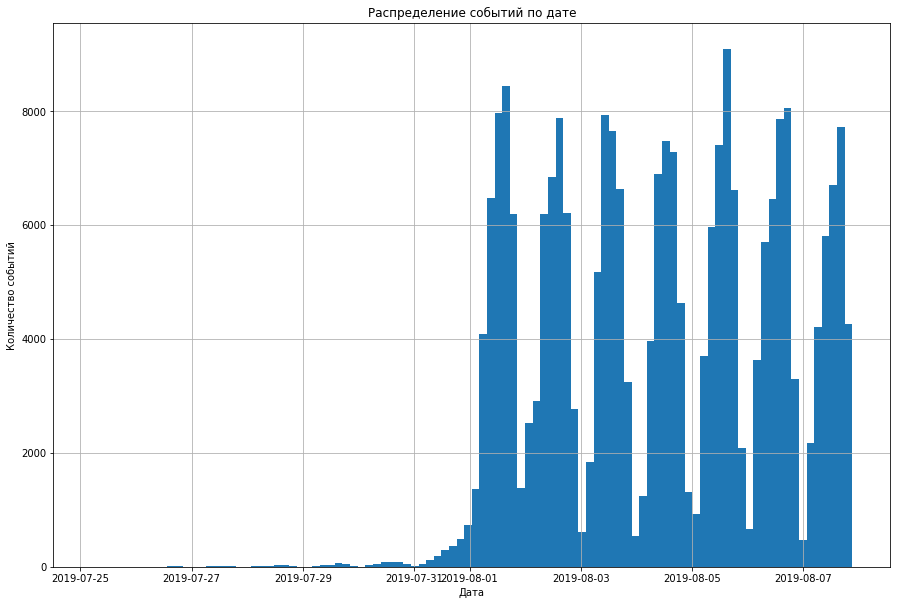

In [21]:
#построим гистограмму:
df['dt'].hist(bins=100,  figsize=(15, 10))
plt.title('Распределение событий по дате')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.show()

*Даны данные с 25.07.19 по 07.08.2019, однако по гистограмме видно что мы обладает полными данными только  с 01.08.19.*

In [22]:
#отбросим период с неполными датами:
df_act = df.query('dt >= "2019-08-01"')

In [23]:
#посчитаем потерю событий:
len(df) - len(df_act)

2826

In [24]:
print(f"доля потерянных событий {(len(df) - len(df_act))/len(df):.1%}")

доля потерянных событий 1.2%


In [25]:
#посчитаем потерю пользователей:
df['user_id'].nunique()-df_act['user_id'].nunique()

17

In [26]:
print(f"доля потерянных пользователей {(df['user_id'].nunique()-df_act['user_id'].nunique())/df['user_id'].nunique():.1%}")

доля потерянных пользователей 0.2%


In [27]:
#проверим, есть ли пользователи из всех трёх экспериментальных групп.
df_act.pivot_table(index = 'group', values = 'user_id', aggfunc = 'count')

,user_id
group,
246,79302
247,77022
248,84563


**На 3 шаге мы:**
1) Посчитали сколько событий в логе: 243713;

2) Посчитали количство уникальных пользователей: 7551;

3) Посчитали сколько событий в среднем приходится на пользователя: 20;

4) Определили минимальную и максимальную дату событий: 2019-07-25 и 2019-08-07 соответственно, однако полные данные оказались лишь 2019-08-01 по 2019-08-07;

5) Обросили неполные данные и посчитали потери:

    -потеря событий всего 2826 из 243713 (1,2%)
    
    -потеря пользователей 17 из 7551 (0,2%)

## Шаг 4. Изучите воронку событий.

#### 1. Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [28]:
df_act.groupby('event_name').agg(count = ('user_id', 'count')).sort_values(by = 'count', ascending=False)

,count
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


#### 2. Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [29]:
user_per_event = df_act.groupby('event_name').agg(users=('user_id','nunique')).sort_values('users', ascending=False)
user_per_event['ratio'] = round(user_per_event['users']/df_act['user_id'].nunique() * 100, 2)
user_per_event

,users,ratio
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


#### 3. Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?

**Предположим, что пользователь**

- сначала открывает главную страницу приложения(MainScreenAppear);
- потом в каталоге выбирает товары(OffersScreenAppear);
- кладёт их в корзину(CartScreenAppear);
- оплачивает(PaymentScreenSuccessful).

*руководство в эту цепочку не входит(Tutorial)*

#### 4. По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [30]:
#создадим сводную таблицу с количеством уникальных пользователей совершавших каждое из событий
user_to_event = df.query('event_name != "Tutorial"').pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique').sort_values(by = 'user_id', ascending = False)
#добавим столбец со смещенными значениями количества пользователей методом shift
#недостающее значение заполним первым значением столбца параметром fill_value
user_to_event['shift'] = user_to_event['user_id'].shift(1, fill_value = user_to_event['user_id'].loc[user_to_event.index[0]])
#посчитаем и добавим столбец с конверсией округленной до 1 десятка
user_to_event['conversion'] = round(user_to_event['user_id']/user_to_event['shift']*100, 1)
#в итоговой таблице оставим только количество уникальных пользователей и конверсией
user_to_event = user_to_event[['user_id', 'conversion']]
user_to_event

,user_id,conversion
event_name,,
MainScreenAppear,7439,100.0
OffersScreenAppear,4613,62.0
CartScreenAppear,3749,81.3
PaymentScreenSuccessful,3547,94.6


#### 5. На каком шаге теряете больше всего пользователей?

*Большинство пользователей теряется после первого шага(чуть меньше половины)*

#### 6. Какая доля пользователей доходит от первого события до оплаты?

In [31]:
print(f"Доля пользователей прошедших от первого события до оплаты {user_to_event['user_id'].loc[user_to_event.index[-1]]/user_to_event['user_id'].loc[user_to_event.index[0]]:.1%}")

Доля пользователей прошедших от первого события до оплаты 47.7%


**На 4 шаге мы:**
1) Посмотрели, как часто встречаются события в логе:

    - MainScreenAppear - 117328 раз;
    
    - OffersScreenAppear - 46333 раз;
    
    - CartScreenAppear - 42303 раз;
    
    - PaymentScreenSuccessful - 33918 раз;
    
    - Tutorial - 1005 раз.

2) Посчитали, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие:

    - MainScreenAppear - 7419 пользователей (98.47%);
    
    - OffersScreenAppear - 4593 пользователей (60.96%);
    
    - СartScreenAppear - 3734 пользователей (49.56%);
    
    - PaymentScreenSuccessful - 3539 пользователей (46.97%);
    
    - Tutorial - 840 пользователей (11.15%).

3) Предположили, в каком порядке происходят события:

    - сначала открывает главную страницу приложения(MainScreenAppear);
    
    - потом в каталоге выбирает товары(OffersScreenAppear);
    
    - кладёт их в корзину(CartScreenAppear);
    
    - оплачивает(PaymentScreenSuccessful).
    
    Откинули событие Tutorial, так как руководство в эту цепочку не входит
    

4) По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):
    
    - на первом шаге 7419 пользователей;
    - до второго шага доходит 4613 пользователей, доля от предыдущего шага 62.0%;
    - до третьего шага доходит 3749 пользователей, доля от предыдущего шага 81.3%;
    - до четвертого шага доходит 3547, доля от предыдущего шага 94.6%

5) Определили, что больше всего пользователей теряется на первом шаге: доля оплативших товар от тех кто дошел до просмотра корзины 62.0%.

6) Посчитали, что доля пользователей прошедших от первого события до оплаты 47.7%.

## Шаг 5. Изучите результаты эксперимента.

#### 1. Сколько пользователей в каждой экспериментальной группе?

In [32]:
df_act.pivot_table(index = 'group', values = 'user_id', aggfunc = 'nunique')

,user_id
group,
246,2484
247,2513
248,2537


*есть незначительная разница в количестве пользователей в каждой эксперементальной группе*

#### 2. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

**Критерии успешного A/A-теста:**

Количество пользователей в различных группах различается не более, чем на 1%;

Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;

Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;

Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

#### 3. Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). 

In [33]:
#Создадим отдельные датасеты с группами
group_246 = df_act.query('group == 246')
group_247 = df_act.query('group == 247')
group_248 = df_act.query('group == 248')

In [34]:
#самое популярное событие в группе 246
group_246.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique').sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


In [35]:
#самое популярное событие в группе 247
group_247.pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique').sort_values(by = 'user_id', ascending = False)

,user_id
event_name,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


**Гипотезы:**

*H0:Между долями статистической значимой разницы нет, поведение групп не отличается;*

*H1:Между долями статистическая значимая разница есть, поведение групп отличается.*

In [36]:
#критический уровень статистической значимости
alpha = 0.05
    
#количсетво уникальных пользователей совершивших событие в каждой группе 
un_users_event = np.array([group_246[group_246['event_name'] == 'MainScreenAppear']['user_id'].nunique(), group_247[group_247['event_name'] == 'MainScreenAppear']['user_id'].nunique()])
        
#количество уникальных пользователей в группах
un_users_group = np.array([group_246['user_id'].nunique(), group_247['user_id'].nunique()])
    
# пропорция успехов в первой группе:
p1 = un_users_event[0]/un_users_group[0]
# пропорция успехов во второй группе:
p2 = un_users_event[1]/un_users_group[1]
    
# пропорция успехов в комбинированном датасете:
p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
# разница пропорций в датасетах
difference = p1 - p2
    
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/un_users_event[0] + 1/un_users_event[1]))
    
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  
    
#Так как распределение статистики нормальное, вызовем метод cdf()
#Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
#Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
p_value = (1 - distr.cdf(abs(z_value))) * 2
          
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


*обернем все в функцию*

In [37]:
#напишем функцию теста статистических различий между группами
def test(g1, g2, event_name):
    
    #критический уровень статистической значимости
    alpha = 0.05
    
    #количсетво уникальных пользователей совершивших событие в каждой группе 
    un_users_event = np.array([g1[g1['event_name'] == event_name]['user_id'].nunique(), g2[g2['event_name'] == event_name]['user_id'].nunique()])
        
    #количество уникальных пользователей в группах
    un_users_group = np.array([g1['user_id'].nunique(), g2['user_id'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = un_users_event[0]/un_users_group[0]
    # пропорция успехов во второй группе:
    p2 = un_users_event[1]/un_users_group[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/un_users_event[0] + 1/un_users_event[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #Так как распределение статистики нормальное, вызовем метод cdf()
    #Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
    #Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(event_name)
          
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [38]:
#создадим список с уникальными событиями:
event_name_array = df['event_name'].unique()
#создадим цикл, который будет подставлять в функцию уникальные значения собитый:
for event_name in event_name_array:
    test(group_246, group_247, event_name)

MainScreenAppear
p-значение:  0.758737151572354
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2784401253423807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.39432110136773835
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.36593695068605325
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.9791070433857165
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно*

#### 4. Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [39]:
#Аналогично проверим 1 контрольную группу 246 с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(group_246, group_248, event_name)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.941774193649735
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Значимой разницы в поведении пользователей групп 246 и 248 нет*

In [40]:
#Проверим 2 контрольную группу 247 с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(group_246, group_248, event_name)

MainScreenAppear
p-значение:  0.2987450335656847
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.3903369220965023
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.21469452387393084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.32498018019986397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.941774193649735
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Значимой разницы в поведении пользователей групп 247 и 248 нет*

In [41]:
#объеденим группы методом pd.concat
group_246_247 = pd.concat([group_246, group_247])

In [42]:
#Проверим объедененную контрольную группу с группой с изменным шрифтом 248
for event_name in event_name_array:
    test(group_246_247, group_248, event_name)

MainScreenAppear
p-значение:  0.2982116211407275
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7202057779473505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.34982490083868933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.5425331263544062
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Tutorial
p-значение:  0.9207162647272609
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Значимой разницы в поведении пользователей объедененной контрольной группы и эксперементальной группы нет*

Можно сделать вывод о том, что изменение шрифтов в приложении не повлияло на наведение пользователей

#### 5. Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

*Критический уровень статистической значимости мы брали 0.05, это озачает что мы рискуем получить ошибку первого рода в одном из 20 случаев. Мы провели 20 экспериментов. Если бы взяли больший уровень значимости, например 0.1, вероятность увидеть ложноположительный результат была бы выше в 2 раза.*

**на 5 шаге мы:**
1) Узнали сколько уникальных пользователей в каждой группе:

    - в 246 группе 2484 уникальных пользователей;
    
    - в 247 группе 2513 уникальных пользователей;
    
    - в 248 группе 2537 уникальных пользователей.
    
2) Выбрали самое популярное событие. Посчитали число пользователей, совершивших это событие в каждой из контрольных групп. Посчитали долю пользователей, совершивших это событие. Проверели, будет ли отличие между группами статистически достоверным. Проделали то же самое для всех других событий.

3) создали функцию для теста статистических различий между группами для каждого события.

4) Аналогично поступили с группой с изменённым шрифтом: 

    - сравнили результаты с каждой из контрольных групп в отдельности по каждому событию;
    
    - сравнили результаты с объединённой контрольной группой.
    
Полученные выводы:

    1. сравнение групп 246 и 247:
        - Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно.
    2. сравнение групп 246 и 248:
        - Значимой разницы в поведении пользователей групп 246 и 248 нет.
    3. сравнение групп 247 и 248:
        - Значимой разницы в поведении пользователей групп 247 и 248 нет.
    4. сравнение групп 246+247 и 248:
        - Значимой разницы в поведении пользователей объедененной контрольной группы и эксперементальной группы нет.

## Общий вывод.

**Описание проекта**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Описание данных**
Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


**На 1 шаге мы:**

1) импортировали библиотеки;

2) записали данные в датафрейм;

3) изучили общую информацию о полученном датафрейме.


**На шаге подготовки данных мы:**

1) переписали названия столбцов для удобства;

2) проверили датафреймы на пропуски и дубликаты;

3) добавили новые столбцы с типами данных datetime;

4) Проверили отсутствие пересечения пользователей в группах: пересечений нет.


**На шаге изучения данных мы:**

1) Посчитали сколько событий в логе: 243713;

2) Посчитали количство уникальных пользователей: 7551;

3) Посчитали сколько событий в среднем приходится на пользователя: 20;

4) Определили минимальную и максимальную дату событий: 2019-07-25 и 2019-08-07 соответственно, однако полные данные оказались лишь 2019-08-01 по 2019-08-07;

5) Обросили неполные данные и посчитали потери:

    -потеря событий всего 2826 из 243713 (1,2%)
    
    -потеря пользователей 17 из 7551 (0,2%)
    

**На шаге изучения воронки событий мы:**

1) Посмотрели, как часто встречаются события в логе:

    - MainScreenAppear - 117328 раз;
    
    - OffersScreenAppear - 46333 раз;
    
    - CartScreenAppear - 42303 раз;
    
    - PaymentScreenSuccessful - 33918 раз;
    
    - Tutorial - 1005 раз.

2) Посчитали, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие:

    - MainScreenAppear - 7419 пользователей (98.47%);
    
    - OffersScreenAppear - 4593 пользователей (60.96%);
    
    - СartScreenAppear - 3734 пользователей (49.56%);
    
    - PaymentScreenSuccessful - 3539 пользователей (46.97%);
    
    - Tutorial - 840 пользователей (11.15%).

3) Предположили, в каком порядке происходят события:

    - сначала открывает главную страницу приложения(MainScreenAppear);
    
    - потом в каталоге выбирает товары(OffersScreenAppear);
    
    - кладёт их в корзину(CartScreenAppear);
    
    - оплачивает(PaymentScreenSuccessful).
    
    Откинули событие Tutorial, так как руководство в эту цепочку не входит
    

4) По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):
    
    - на первом шаге 7419 пользователей;
    - до второго шага доходит 4613 пользователей, доля от предыдущего шага 62.0%;
    - до третьего шага доходит 3749 пользователей, доля от предыдущего шага 81.3%;
    - до четвертого шага доходит 3547, доля от предыдущего шага 94.6%

5) Определили, что больше всего пользователей теряется на первом шаге: доля оплативших товар от тех кто дошел до просмотра корзины 62.0%.

6) Посчитали, что доля пользователей прошедших от первого события до оплаты 47.7%.


**На шаге изучения результатов эксперимента мы:**

1) Узнали сколько уникальных пользователей в каждой группе:

    - в 246 группе 2484 уникальных пользователей;
    
    - в 247 группе 2513 уникальных пользователей;
    
    - в 248 группе 2537 уникальных пользователей.
    
2) Выбрали самое популярное событие. Посчитали число пользователей, совершивших это событие в каждой из контрольных групп. Посчитали долю пользователей, совершивших это событие. Проверели, будет ли отличие между группами статистически достоверным. Проделали то же самое для всех других событий.

3) создали функцию для теста статистических различий между группами для каждого события.

4) Аналогично поступили с группой с изменённым шрифтом: 

    - сравнили результаты с каждой из контрольных групп в отдельности по каждому событию;
    
    - сравнили результаты с объединённой контрольной группой.
    
Полученные выводы:

    1. сравнение групп 246 и 247:
        - Статистические критерии разницу между выборками 246 и 247 не находят, т.к. ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными. Разбиение на группы работает корректно.
    2. сравнение групп 246 и 248:
        - Значимой разницы в поведении пользователей групп 246 и 248 нет.
    3. сравнение групп 247 и 248:
        - Значимой разницы в поведении пользователей групп 247 и 248 нет.
    4. сравнение групп 246+247 и 248:
        - Значимой разницы в поведении пользователей объедененной контрольной группы и эксперементальной группы нет.
    5. Критический уровень статистической значимости мы брали 0.05, это озачает что мы рискуем получить ошибку первого рода в одном из 20 случаев. Мы провели 20 экспериментов. Если бы взяли больший уровень значимости, например 0.1, вероятность увидеть ложноположительный результат была бы выше в 2 раза.
    
    
**Вывод:**

Множесто А/В-тестов, проведённых по каждому из событий, не обнаружили статистически значимой разницы между группами. Т.е. изменение шрифтов в приложении на поведение пользователей не повлияло.